# 1. Подготовка данных

## 1.1 Скачивание и распаковка датасета

In [6]:
import requests

url = "https://storage.yandexcloud.net/academy.ai/russian_literature.zip"
r = requests.get(url)

with open("russian_literature.zip", "wb") as f:
    f.write(r.content)
print("Архив скачан")

Архив скачан


In [2]:
import zipfile
import os

extract_path = './dataset'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile("russian_literature.zip", 'r') as zip_ref:
    # Счётчики для каждого каталога, чтобы нумеровать файлы отдельно в каждой папке
    counters = {}

    for info in zip_ref.infolist():
        if info.is_dir():
            # Создаём папки как есть
            full_dir_path = os.path.join(extract_path, info.filename)
            os.makedirs(full_dir_path, exist_ok=True)
        else:
            # Получаем путь папки внутри архива
            folder = os.path.dirname(info.filename)
            ext = os.path.splitext(info.filename)[1].lower()

            # Создаём папку, если не существует
            full_folder_path = os.path.join(extract_path, folder)
            os.makedirs(full_folder_path, exist_ok=True)

            # Если файл с расширением .txt — переименовываем
            if ext == '.txt':
                counters.setdefault(folder, 0)
                counters[folder] += 1
                new_filename = f"file_{counters[folder]:04d}.txt"
            else:
                # Для остальных файлов оставляем оригинальное имя
                new_filename = os.path.basename(info.filename)

            full_path = os.path.join(full_folder_path, new_filename)

            with zip_ref.open(info) as source, open(full_path, "wb") as target:
                target.write(source.read())

print(f"Архив распакован в '{extract_path}' с переименованными .txt файлами.")


Архив распакован в './dataset' с переименованными .txt файлами.


## 1.2 Выбор 5 авторов с наибольшим объемом текста

In [1]:
CLASS_LIST = ["Dostoevsky", "Tolstoy", "Turgenev", "Chekhov", "Gorky"]

# 2. Токенизация с использованием Razdel

In [2]:
from razdel import tokenize
import glob
from pymorphy3 import MorphAnalyzer
import re

In [3]:
 # Инициализация морфологического анализатора
morph = MorphAnalyzer()

def lemmatize_text(text):
    return ' '.join([morph.parse(word)[0].normal_form for word in text.split()])

def preprocess_text(text):
    text = re.sub(r'[^а-яёА-ЯЁ ]', ' ', text)
    text = text.lower()
    return lemmatize_text(text)

def razdel_tokenize(text):
    text = preprocess_text(text)
    return [t.text for t in tokenize(text)]

In [4]:
from tqdm import tqdm
import os
from concurrent.futures import ProcessPoolExecutor


In [5]:
import concurrent.futures 

def process_file(path):
    try:
        with open(path, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read().replace('\n', ' ')
            tokens = razdel_tokenize(text)
            return ' '.join(tokens)
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None

all_texts = {}
for author in CLASS_LIST:
    prose_paths = glob.glob(os.path.join('dataset', 'prose', author, '*.txt'))
    poems_paths = glob.glob(os.path.join('dataset', 'poems', author, '*.txt'))
    all_paths = prose_paths + poems_paths

    all_texts[author] = []

    # Параллельная обработка с прогресс-баром
    with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
        results = list(tqdm(executor.map(process_file, all_paths), total=len(all_paths), desc=f"Обработка: {author}"))

    # Отбрасываем None (ошибки)
    all_texts[author].extend([r for r in results if r is not None])

Обработка: Gorky: 100%|██████████| 33/33 [00:38<00:00,  1.18s/it]


# 3. Токенизация и подготовка данных

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

embedding_dim = 300
max_words = 10000
tokenizer = Tokenizer(num_words=max_words, lower=True)
tokenizer.fit_on_texts(texts)

texts = []
labels = []
for idx, author in enumerate(CLASS_LIST):
    texts.extend(all_texts[author])
    labels.extend([idx] * len(all_texts[author]))

sequences = tokenizer.texts_to_sequences(texts)

In [18]:
# Ограничим 40_000 токенов на автора
seq_train_balance = [seq[:40000] for seq in sequences]

# 4. Балансировка и деление

In [19]:
import numpy as np
from keras.utils import to_categorical


In [20]:
WIN_SIZE = 500
WIN_STEP = 50
X = []
y = []
for idx, seq in enumerate(seq_train_balance):
    for i in range(0, len(seq) - WIN_SIZE, WIN_STEP):
        X.append(seq[i:i+WIN_SIZE])
        y.append(labels[idx])

X = np.array(X)
y = to_categorical(np.array(y), num_classes=len(CLASS_LIST))

Разделим на train/val/test (0.8 / 0.1 / 0.1)

In [21]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42)


# 5. Подключение предобученных весов Natasha

скачивание Наташа

In [24]:
import requests

url = 'https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar'
local_path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(local_path, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

In [25]:
from navec import Navec
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

embedding_matrix = np.zeros((max_words, embedding_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < max_words and word in navec:
        embedding_matrix[i] = navec[word]

# 6. Построение и обучение модели

In [26]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

model = Sequential([
    Embedding(max_words, embedding_dim, weights=[embedding_matrix], trainable=False),
    Conv1D(128, 5, activation='relu', padding='same'),
    Conv1D(128, 7, activation='relu', padding='same'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(CLASS_LIST), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Колбэки: сохранение лучшей модели + ранняя остановка
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True)
earlystop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

## Первый этап обучения (embedding заморожен)

In [27]:
# Обучение
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=128,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/3
284/284 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - accuracy: 0.5399 - loss: 1.1304 - val_accuracy: 0.9678 - val_loss: 0.1377
Epoch 2/3
284/284 ━━━━━━━━━━━━━━━━━━━━ 40s 141ms/step - accuracy: 0.9662 - loss: 0.1341 - val_accuracy: 0.9945 - val_loss: 0.0263
Epoch 3/3
284/284 ━━━━━━━━━━━━━━━━━━━━ 38s 135ms/step - accuracy: 0.9923 - loss: 0.0311 - val_accuracy: 0.9956 - val_loss: 0.0149


##  Второй этап - Fine-tuning (разморозка эмбеддинга)

In [29]:
from tensorflow.keras.optimizers import Adam


In [30]:
model.layers[0].trainable = True
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    initial_epoch=3,
    batch_size=128,
    callbacks=[checkpoint, earlystop]
)

Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 50s 175ms/step - accuracy: 0.9990 - loss: 0.0078 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 50s 176ms/step - accuracy: 0.9997 - loss: 0.0037 - val_accuracy: 0.9998 - val_loss: 7.0163e-04
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 50s 175ms/step - accuracy: 0.9998 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 4.7355e-04
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 50s 176ms/step - accuracy: 0.9997 - loss: 0.0022 - val_accuracy: 0.9998 - val_loss: 6.5332e-04


# 7. Оценка модели

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.models import load_model

142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Score on test set: 99.88%


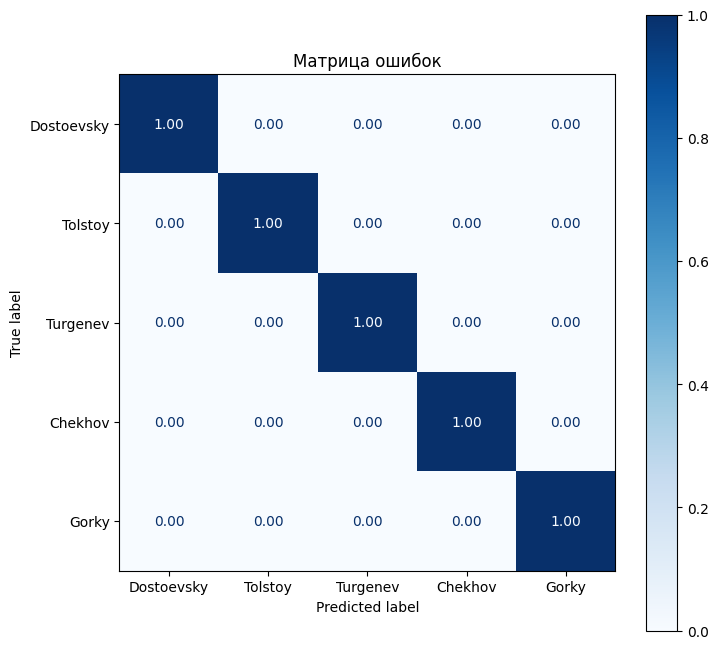

In [38]:
model = load_model("best_model.keras")
y_pred = model.predict(X_test)
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), normalize='true')
acc = np.mean(np.diag(cm))
print(f'Score on test set: {acc*100:.2f}%')

fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_LIST)
disp.plot(ax=ax, cmap='Blues', values_format='.2f')
plt.title("Матрица ошибок")
plt.show()

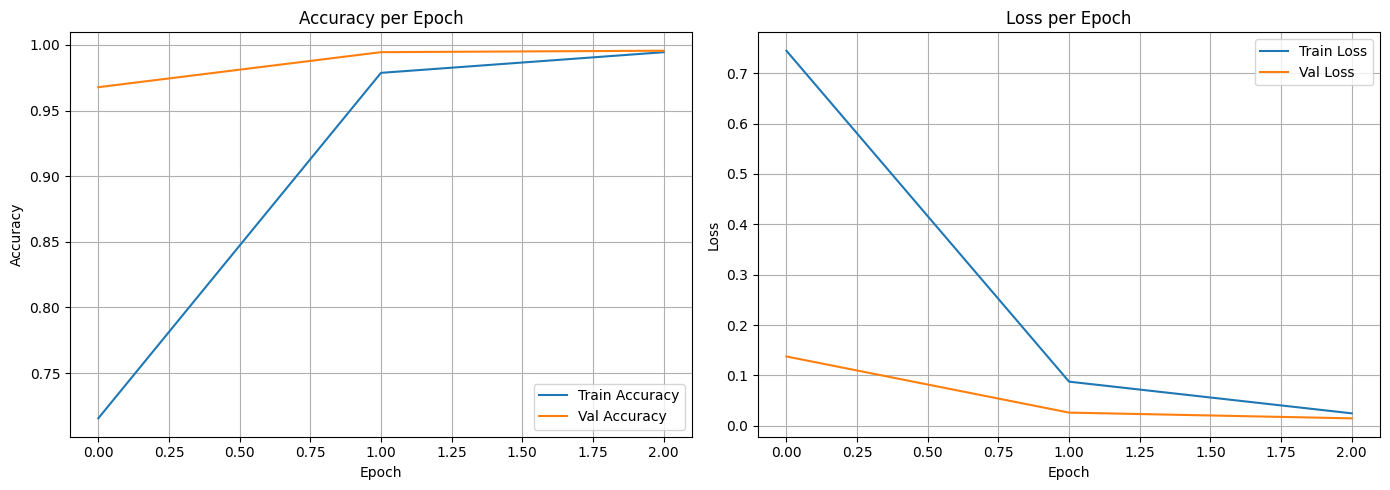

In [40]:
# Графики обучения
def show_training_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax1.set_title('Accuracy per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_title('Loss per Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Вызов
show_training_curves(history)